In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactiveity = 'all'

import numpy as np
import pandas as pd
import yfinance as yf
from scipy.fftpack import fft, ifft, fftfreq
from scipy.interpolate import make_interp_spline
from scipy import stats
import statsmodels.tsa.stattools as ts
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
import statsmodels.api as sm


from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
class Fourier:
    
    def __init__(self, name, start):
        self.name = name
        self.start = start
        self.raw_data = None
        self.ret_monthly = None
        self.ret_mean = None
        self.cycle_data = None
        self.pred_ret_monthly = []
        self.best_params = []
        self.sin_params = []
        self.max_ = []
        
    def _get_raw_data(self):
        self.raw_data = yf.download(self.name, start=self.start)
        
    def _adf(self, data, col, lag=None):
        result = ts.adfuller(data[col], lag)
        return (self.name + ' ' + col + "_ADF-test", result)
    
    def _qq_plot(self, data, col):
        plt.figure(figsize=(10, 10))
#         plt.title("{}_Q_Q_plot".format(self.name))
#         stats.probplot(data[col], dist='norm', plot=plt)
        data = data[[col]]
        data['Quantile'] = data[col].rank(pct=True, ascending=True)
        ax = sns.regplot(x=data[col], y=data['Quantile'], ci=None, color='b',line_kws={'color': 'r'})
        ax.set_title("{}_{}_QQ_plot".format(self.name, col))
        plt.savefig("output/{}_{}_QQ_plot.eps".format(self.name, col),dpi=600)
        
    def _lb_test(self, data, col):
        result = lb_test(data[col])
        return (self.name + ' ' + col + "_Ljung-box-test", result[1].max())
        
    def _calculate_ret(self):
        price = self.raw_data.copy()[['Adj Close']]
        price.index = pd.to_datetime(price.index)
        price = price.resample('M').last()
        ret_12 = (price / price.shift(12) - 1).dropna()
        ret_12.columns = ['ret']
        self.ret_mean = ret_12.mean()[0]
        self.ret_monthly = ret_12 - self.ret_mean
        
    def _plot_monthly_ret(self, width=30, height=10):
#         plt.figure(figsize=(width, height))
        fig, ax1 = plt.subplots(figsize=(width, height))
        plt.title("{} log_price & yoy_return".format(self.name))
        ax1.plot(np.log(self.raw_data[['Adj Close']]), c='r')
        ax1.set_ylabel('Log Price')
        ax2=ax1.twinx() #twinx将ax1的X轴共用与ax2，这步很重要
        ax2.plot(self.ret_monthly, c='g')
        ax2.set_ylabel('YoY Return')
        plt.savefig("output/{} log_price & yoy_return.eps".format(self.name), dpi=600)
    
    def _fourier_transform(self):
        x = np.array(self.ret_monthly[self.ret_monthly.index < '2018-01-01'].index)
        y = np.array(self.ret_monthly[self.ret_monthly.index < '2018-01-01']['ret'])
        y = np.concatenate((y, np.zeros(12 * len(y))),axis=0)
        # 数据长度
        N = len(y)
        # 采样频率
        fs = 1
        y_f = fft(y)
        # x_f = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
        x_f = fftfreq(N, 1 / fs)[:N // 2]
        df = pd.DataFrame(np.concatenate((2.0 / N * np.abs(y_f[: N // 2]).reshape(-1, 1), np.angle(y_f[: N // 2]).reshape(-1, 1)), axis=1), columns=['A', 'Phi'], index=x_f)
        df['T'] = 1 / df.index
        df.set_index('T', inplace=True)
        self.cycle_data = df.iloc[: 0: -1]
        self.cycle_data.iloc[-1, 0] = 0
        
    def _plot_spec(self, width=30, height=10):
        max_ = pd.DataFrame([], columns=['A', 'Phi'])
        for i in range(1, len(self.cycle_data) - 1):
            if self.cycle_data.iloc[i, 0] > self.cycle_data.iloc[i - 1, 0] and \
                self.cycle_data.iloc[i, 0] > self.cycle_data.iloc[i + 1, 0]:
                max_.loc[self.cycle_data.index[i]] = self.cycle_data.iloc[i]
        max_.sort_values(by=['A'], ascending=False, inplace=True)
        self.max_ = max_
        plt.figure(figsize=(width, height))
        plt.title("{}_Spectrogram".format(self.name))
        self.best_params.append((round(max_.index[0], 1), round(max_.iloc[0, 1] + np.pi / 2, 3)))
        self.best_params.append((round(max_.index[1], 1), round(max_.iloc[1, 1] + np.pi / 2, 3)))

        # 标点
        plt.scatter(max_.index[0], max_.iloc[0, 0], s=25, c='r')
        plt.text(max_.index[0], max_.iloc[0, 0], "({}, {})".format(str(round(max_.index[0], 1)), str(round(max_.iloc[0, 0], 4))), ha='center', va='bottom', fontsize=10)
        plt.scatter(max_.index[1], max_.iloc[1, 0], s=25, c='r')
        plt.text(max_.index[1], max_.iloc[1, 0], "({}, {})".format(str(round(max_.index[1], 1)), str(round(max_.iloc[1, 0], 4))), ha='center', va='bottom', fontsize=10)
        plt.plot(self.cycle_data.iloc[:len(self.cycle_data) - 10, 0])
        plt.savefig("output/{}_Spectrogram.eps".format(self.name), dpi=600)

        
    def _filter(self, T=42.9, Phi=0.1, width=20, height=10):
        ret_train = self.ret_monthly[self.ret_monthly.index < '2018-01-01']
        t = np.arange(len(ret_train))
        A = 0.3
#         Phi1 = 0.1
        y = A * np.sin(2 * np.pi / T * t + Phi)
        lr = 0.005
        cnt = 0
        ret_np = np.array(ret_train['ret'])

        while(True):
            cnt += 1
            cost_A = ((y - ret_np) * np.sin(2 * np.pi / T * t + Phi)).sum()
#             cost_Phi1 = ((y - ret_np) * np.cos(2 * np.pi / T * t + Phi)).sum()
            A = A - lr * cost_A
#             Phi = Phi - lr * cost_Phi1
            y = A * np.sin(2 * np.pi / T * t + Phi)
            if cnt == 50:
                break
        
        new_t = np.arange(len(self.ret_monthly))
        new_y = A * np.sin(2 * np.pi / T * new_t + Phi)
                          
        plt.figure(figsize=(width, height))
        plt.title("{}_{}months_Filter".format(self.name, T))
        plt.plot(self.ret_monthly.index.to_list(), new_y)
        plt.plot(ret_train.index.to_list(),ret_np)
        plt.savefig("output/{}_{}months Filter.eps".format(self.name, T), dpi=600)
        self.sin_params.append((Phi, A, T))
        self.pred_ret_monthly.append(new_y)
        
    def _filter_2(self, T1=42.9, T2=93, Phi1=0.1, Phi2=0.1, width=20, height=10):
        ret_train = self.ret_monthly[self.ret_monthly.index < '2018-01-01']
        t = np.arange(len(ret_train))
        A1 = 0.1
        A2= 0.1
#         Phi1 = 0.1
#         Phi2 = 0.1
        y = A1 * np.sin(2 * np.pi / T1 * t + Phi1) + A2 * np.sin(2 * np.pi / T2 * t + Phi2)
        lr = 0.005
        cnt = 0
        ret_np = np.array(ret_train['ret'])

        while(True):
            cnt += 1
            cost_A1 = ((y - ret_np) * np.sin(2 * np.pi / T1 * t + Phi1)).sum()
            cost_A2 = ((y - ret_np) * np.sin(2 * np.pi / T2 * t + Phi2)).sum()
#             cost_Phi1 = ((y - ret_np) * np.cos(2 * np.pi / T1 * t + Phi1)).sum()
#             cost_Phi2 = ((y - ret_np) * np.cos(2 * np.pi / T2 * t + Phi2)).sum()
            A1 = A1 - lr * cost_A1
            A2 = A2 - lr * cost_A2
#             Phi1 = Phi1 - lr * cost_Phi1
#             Phi2 = Phi2 - lr * cost_Phi2
            y = A1 * np.sin(2 * np.pi / T1 * t + Phi1) + A2 * np.sin(2 * np.pi / T2 * t + Phi2)
            if cnt == 1000:
                break
        
        new_t = np.arange(len(self.ret_monthly))
        new_y = A1 * np.sin(2 * np.pi / T1 * new_t + Phi1) + A2 * np.sin(2 * np.pi / T2 * new_t + Phi2)
                          
        plt.figure(figsize=(width, height))
        plt.title("{}_{}M & {}M_Filter".format(self.name, T1, T2))
        plt.plot(self.ret_monthly.index.to_list(), new_y)
        plt.plot(ret_train.index.to_list(), ret_np)
        plt.savefig("output/{}_{}M & {}M_Filter.eps".format(self.name, T1, T2), dpi=600)
        self.sin_params.append(((Phi1, A1, T1), (Phi2, A2, T2)))
        self.pred_ret_monthly.append(new_y)
        
    @staticmethod
    def _linear_regression(X, y):
        model = sm.OLS(y, X)
        results = model.fit()
        print()
        print(results.summary())
        
    def _stats_pipeline(self):
        self._get_raw_data()
        self._calculate_ret()
        print(self._adf(self.raw_data, 'Adj Close'))
        print(self._adf(self.ret_monthly, 'ret'))
        self._qq_plot(self.raw_data, 'Adj Close')
        self._qq_plot(self.ret_monthly, 'ret')
        print(self._lb_test(self.raw_data, 'Adj Close'))
        print(self._lb_test(self.ret_monthly, 'ret'))
        
    def _cycle_pipeline(self):
        self._plot_monthly_ret()
        self._fourier_transform()
        self._plot_spec()
        self._filter(self.best_params[0][0], self.best_params[0][1])
        print(self.sin_params[-1])
        self._linear_regression(X=self.pred_ret_monthly[-1], y=np.array(self.ret_monthly['ret']))
        self._filter(self.best_params[1][0], self.best_params[1][1])
        print(self.sin_params[-1])
        self._linear_regression(X=self.pred_ret_monthly[-1], y=np.array(self.ret_monthly['ret']))
        self._filter_2(self.best_params[0][0], self.best_params[1][0], self.best_params[0][1], self.best_params[1][1])
        print(self.sin_params[-1])
        self._linear_regression(X=self.pred_ret_monthly[-1], y=np.array(self.ret_monthly['ret']))
        
    def _start(self):
        print('\n\n----------', self.name, '----------')


In [3]:
class Multi_Fourier_Comparison:
    def __init__(self, names):
        self.Fouriers = [Fourier(name, '1988-01-01') for name in names]

    def _plot(self):
        for f in self.Fouriers:
            f._start()
            f._stats_pipeline()
            f._cycle_pipeline()

        plt.figure(figsize=(20, 10))
        plt.title("Spectrograms Comparison")
        for f in self.Fouriers:
            f.cycle_data.columns = [f.name + 'A', f.name + 'Phi']
            max_ = pd.DataFrame([], columns=[f.name + 'A', f.name + 'Phi'])
            for i in range(1, len(f.cycle_data) - 1):
                if f.cycle_data.iloc[i, 0] > f.cycle_data.iloc[i - 1, 0] and \
                    f.cycle_data.iloc[i, 0] > f.cycle_data.iloc[i + 1, 0]:
                    max_.loc[f.cycle_data.index[i]] = f.cycle_data.iloc[i, 0]
            max_.sort_values(by=[f.name + 'A'], ascending=False, inplace=True)

            # 标点
            plt.scatter(max_.index[0], max_.iloc[0, 0], s=25, c='r')
            plt.text(max_.index[0],
                     max_.iloc[0, 0],
                     "({}, {})".format(str(round(max_.index[0], 1)),
                                       str(round(max_.iloc[0, 0], 4))),
                     ha='center',
                     va='bottom',
                     fontsize=10)
            plt.scatter(max_.index[1], max_.iloc[1, 0], s=25, c='r')
            plt.text(max_.index[1],
                     max_.iloc[1, 0],
                     "({}, {})".format(str(round(max_.index[1], 1)),
                                       str(round(max_.iloc[1, 0], 4))),
                     ha='center',
                     va='bottom',
                     fontsize=10)
            plt.plot(f.cycle_data.iloc[:len(f.cycle_data) - 10, 0], label=f.name)
        plt.legend()
        plt.savefig('output/diff_indices_contrast.eps', dpi=600)



---------- ^RUA ----------
[*********************100%***********************]  1 of 1 completed


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('^RUA Adj Close_ADF-test', (2.6046868235312943, 0.9990760073146846, 36, 8535, {'1%': -3.431116405133646, '5%': -2.861878699077286, '10%': -2.5669502846063748}, 64318.713731435826))
('^RUA ret_ADF-test', (-3.6714764388181518, 0.004532729268069124, 15, 382, {'1%': -3.4475850438570115, '5%': -2.869135963767125, '10%': -2.5708164748773332}, -1083.1157146521866))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('^RUA Adj Close_Ljung-box-test', 0.0)
('^RUA ret_Ljung-box-test', 8.898759960723115e-75)
(0.561, 0.1018805906677408, 90.5)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.191
Model:                            OLS   Adj. R-squared (uncentered):              0.189
Method:                 Least Squares   F-statistic:                              93.84
Date:                Wed, 16 Feb 2022   Prob (F-statistic):                    4.63e-20
Time:                        16:58:07   Log-Likelihood:                          208.14
No. Observations:                 398   AIC:                                     -414.3
Df Residuals:                     397   BIC:                                     -410.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                              

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('^GSPC Adj Close_ADF-test', (2.8280281171884107, 1.0, 36, 8564, {'1%': -3.4311138091018725, '5%': -2.86187755195482, '10%': -2.5669496739842286}, 73532.02675650133))
('^GSPC ret_ADF-test', (-3.433872261940543, 0.00985696010197977, 15, 382, {'1%': -3.4475850438570115, '5%': -2.869135963767125, '10%': -2.5708164748773332}, -1108.823249319051))
('^GSPC Adj Close_Ljung-box-test', 0.0)
('^GSPC ret_Ljung-box-test', 2.9561404327912563e-75)
(0.556, 0.1078574133415504, 90.5)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.217
Model:                            OLS   Adj. R-squared (uncentered):              0.215
Method:                 Least Squares   F-statistic:                              110.3
Date:                Wed, 16 Feb 2022   Prob (F-statistic):                    6.25e-23
Time:                        16:58:08   Log-Likelihood:                          220.06

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('^IXIC Adj Close_ADF-test', (3.0303596871139717, 1.0, 36, 8564, {'1%': -3.4311138091018725, '5%': -2.86187755195482, '10%': -2.5669496739842286}, 94271.50373275897))
('^IXIC ret_ADF-test', (-4.076064493898465, 0.0010606175098419794, 14, 383, {'1%': -3.44753973676872, '5%': -2.8691160516676844, '10%': -2.57080585953957}, -778.7948361352526))
('^IXIC Adj Close_Ljung-box-test', 0.0)
('^IXIC ret_Ljung-box-test', 3.376883531949042e-75)
(1.635, 0.17390872928038453, 43.5)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.248
Model:                            OLS   Adj. R-squared (uncentered):              0.246
Method:                 Least Squares   F-statistic:                              130.9
Date:                Wed, 16 Feb 2022   Prob (F-statistic):                    2.16e-26
Time:                        16:58:10   Log-Likelihood:                          58.926


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


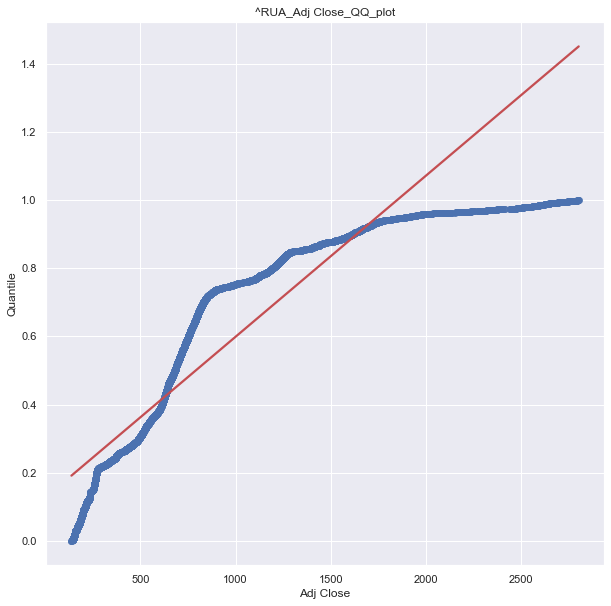

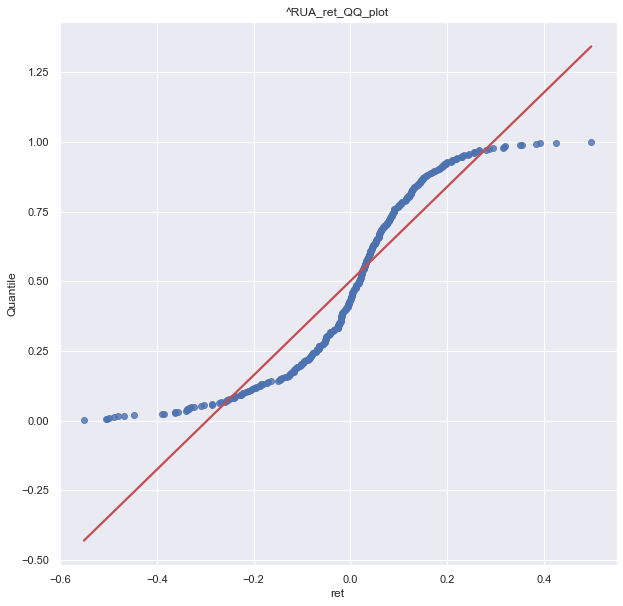

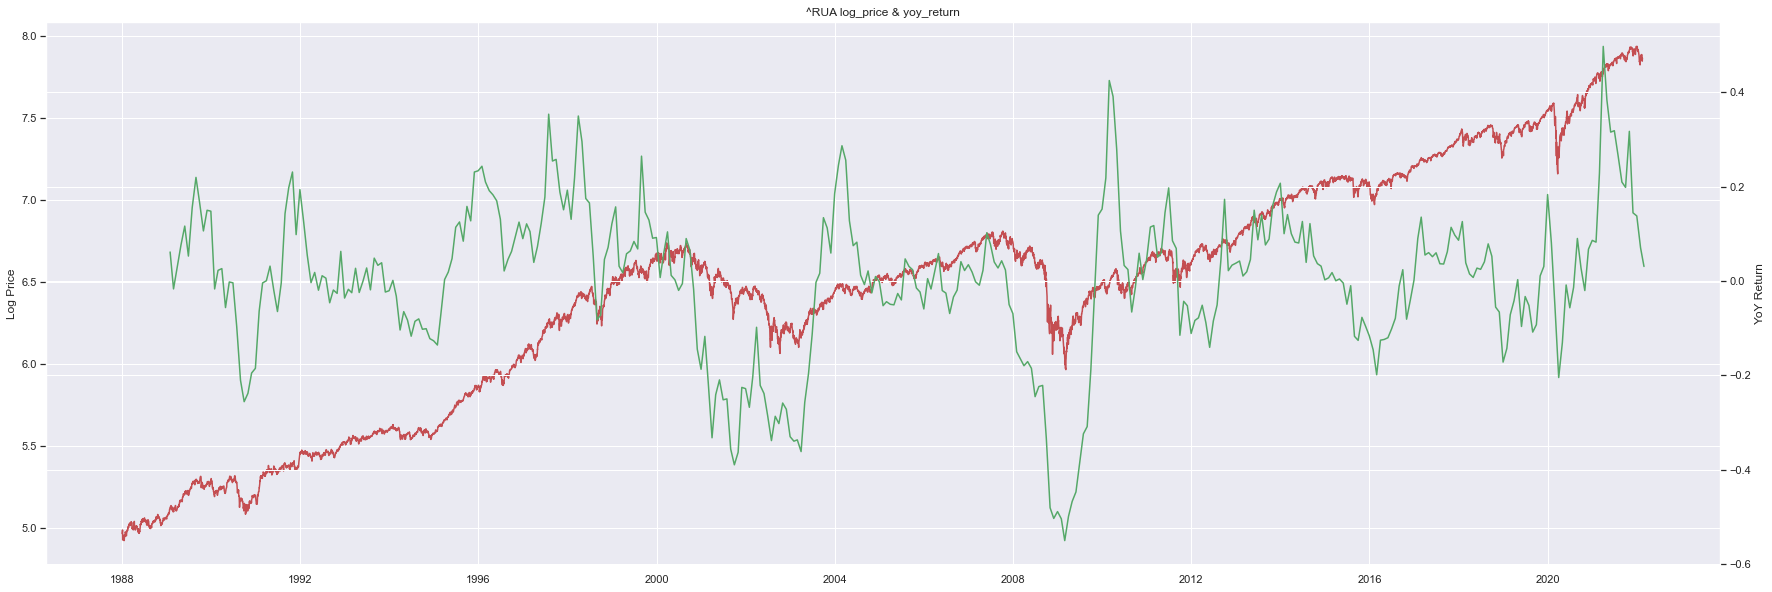

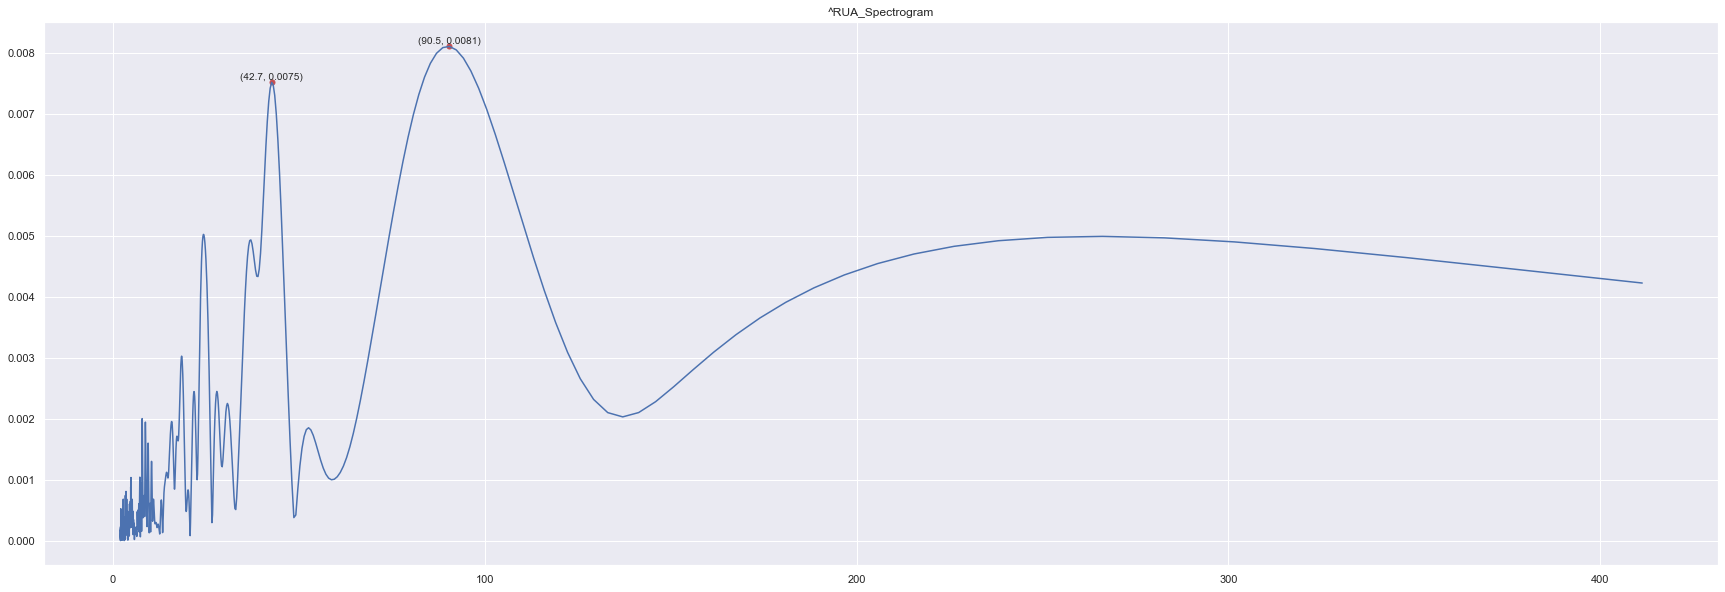

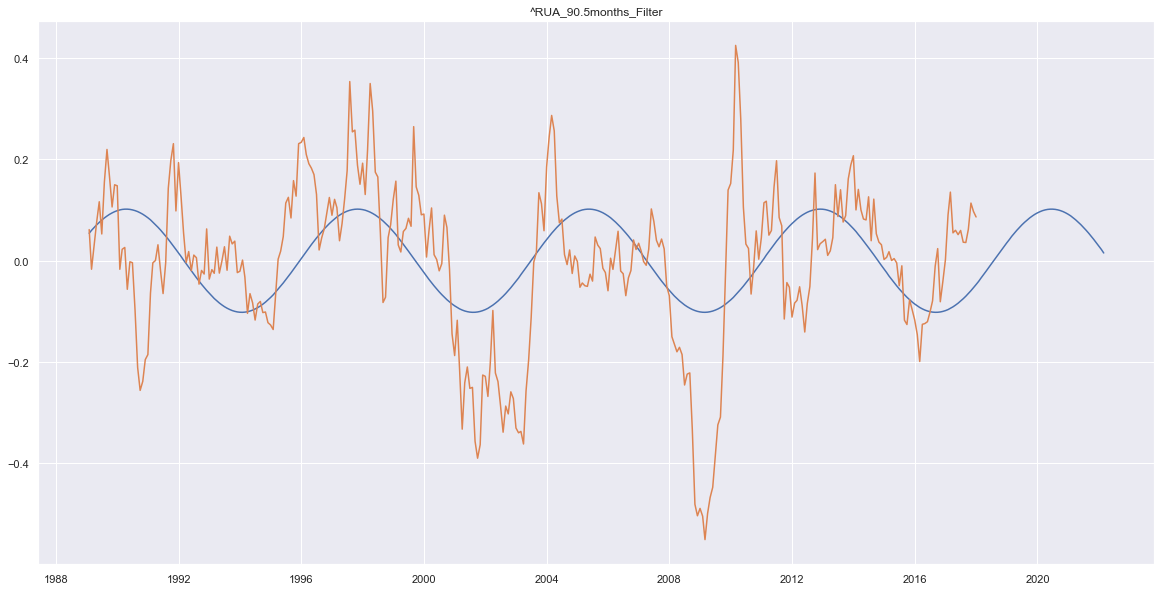

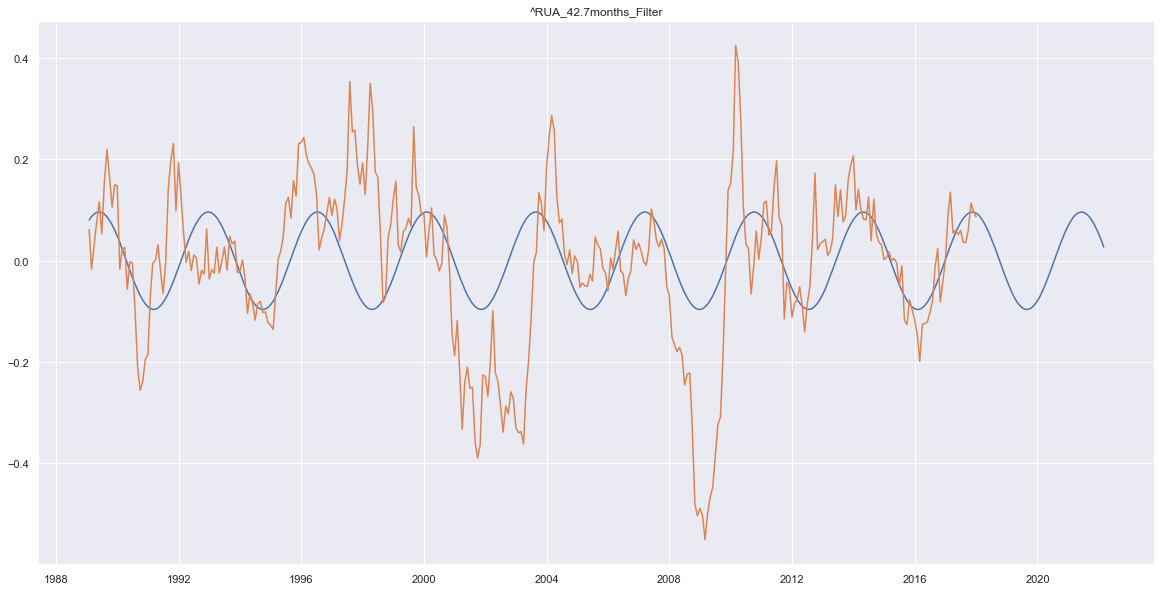

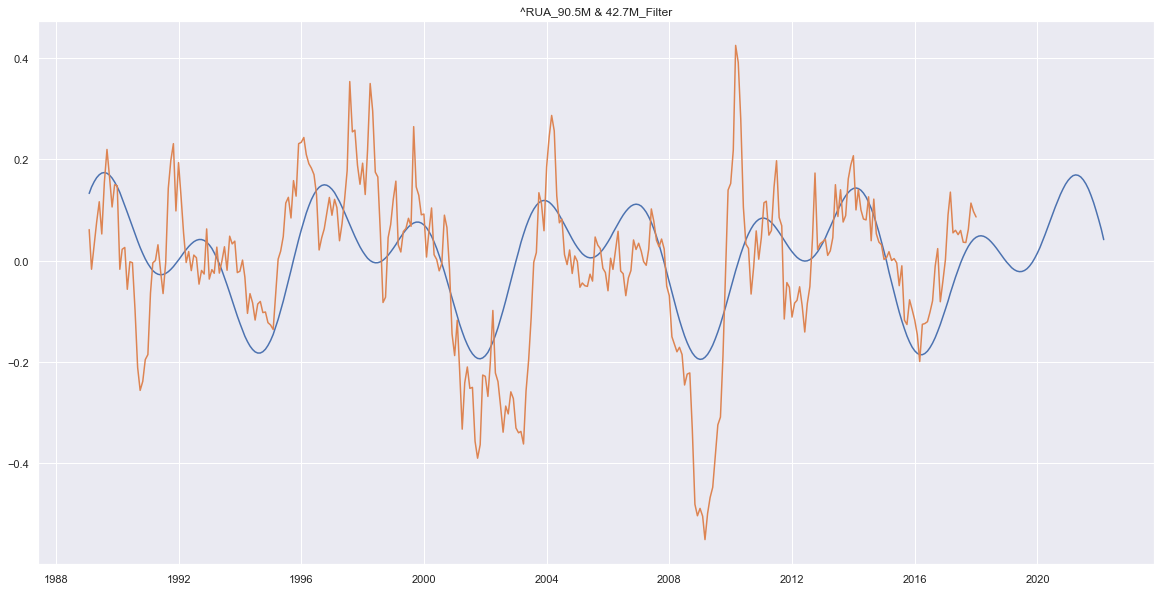

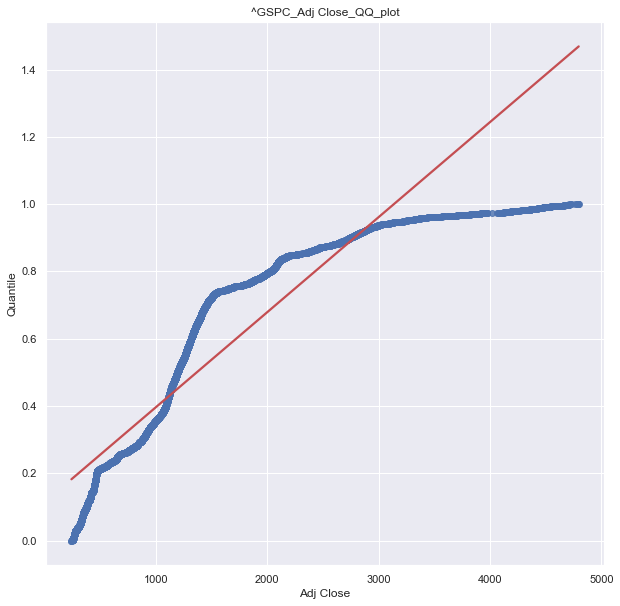

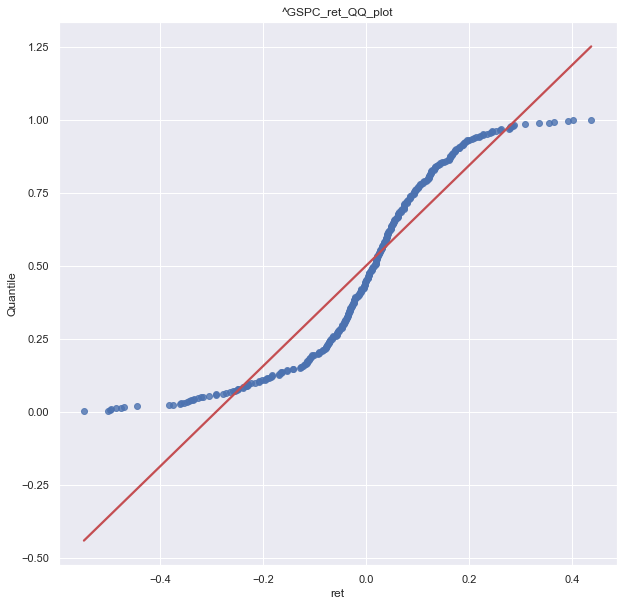

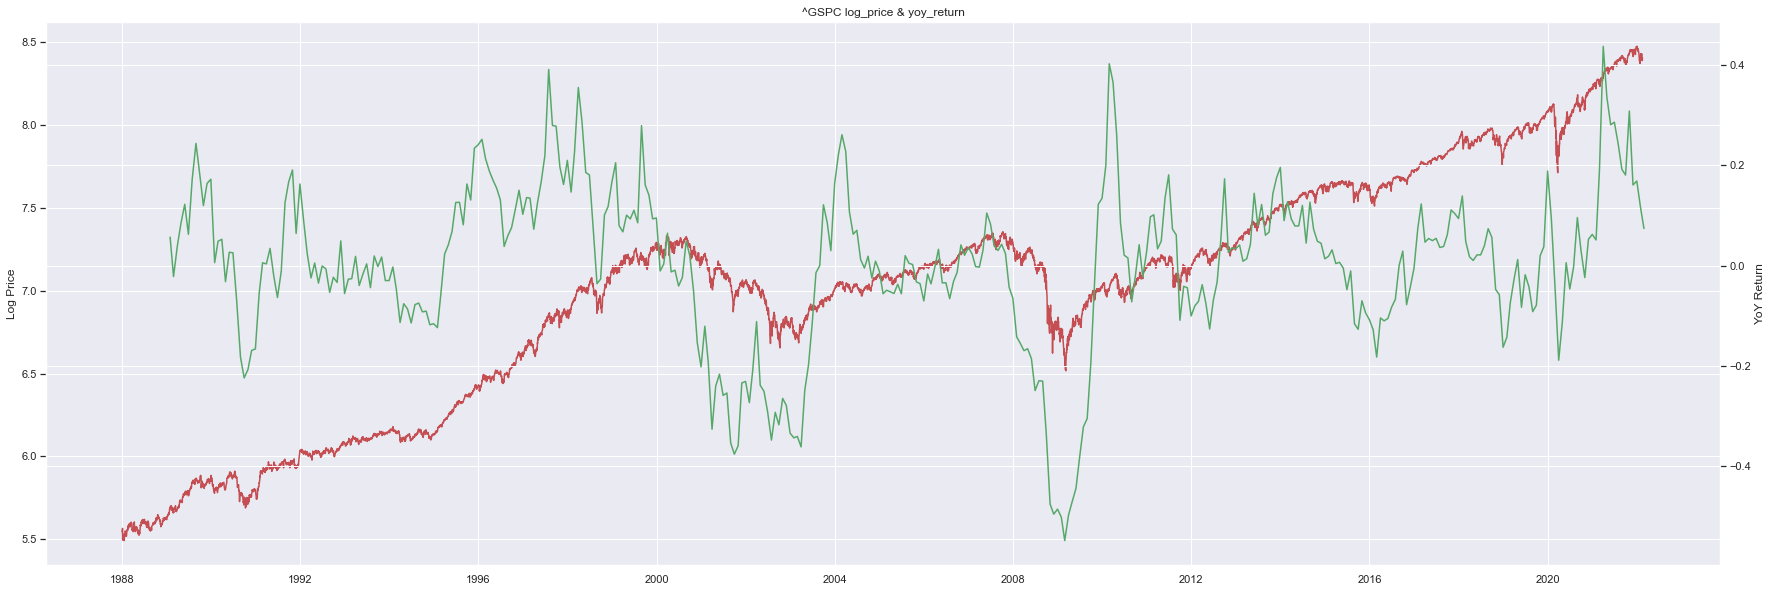

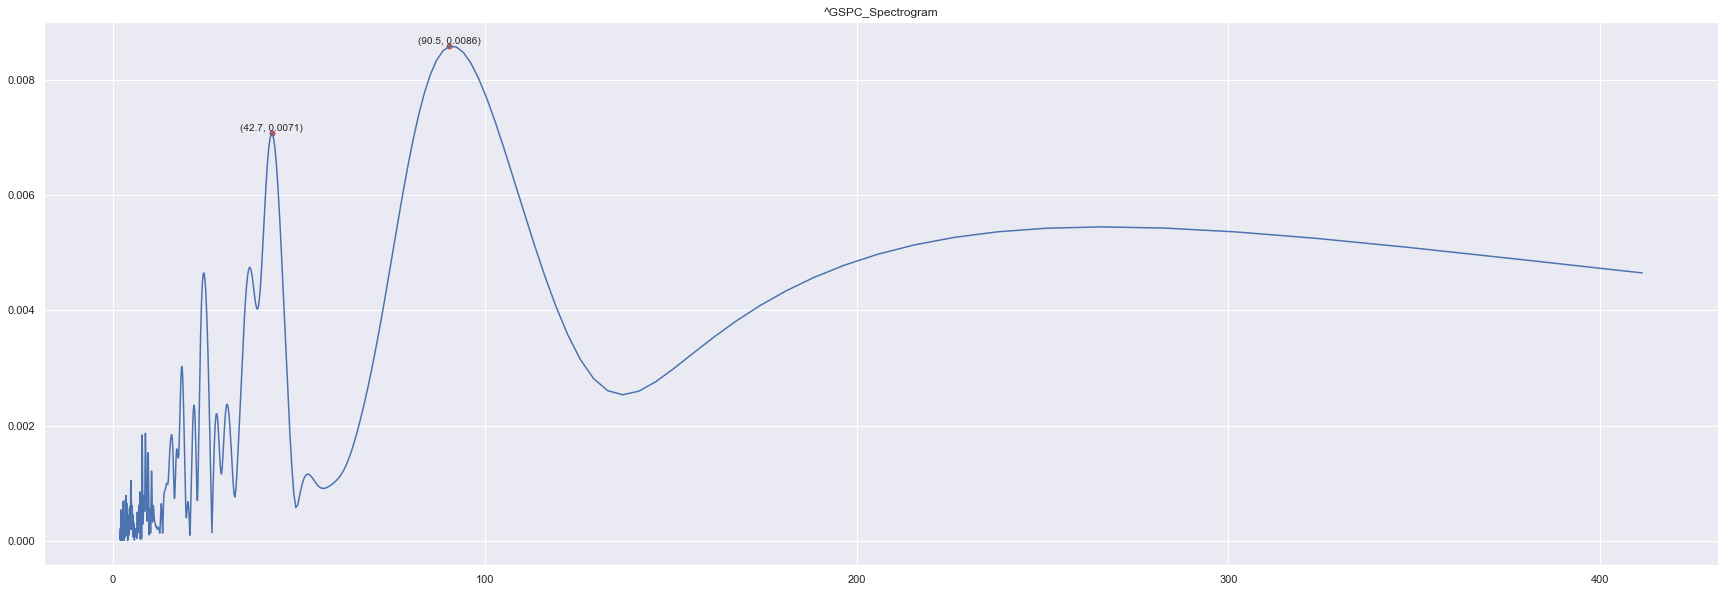

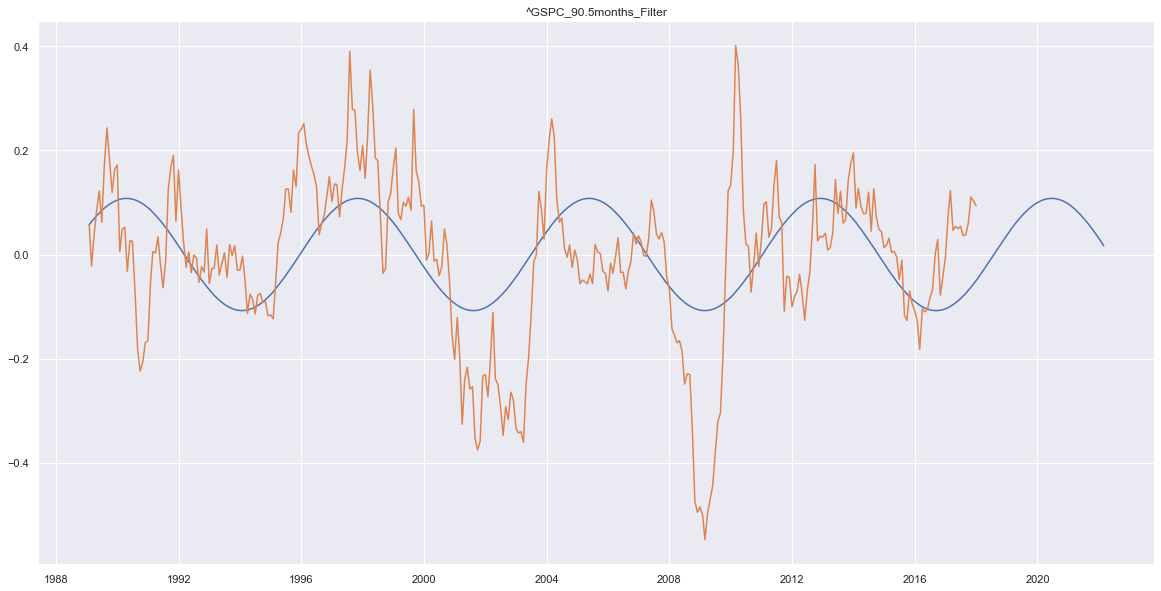

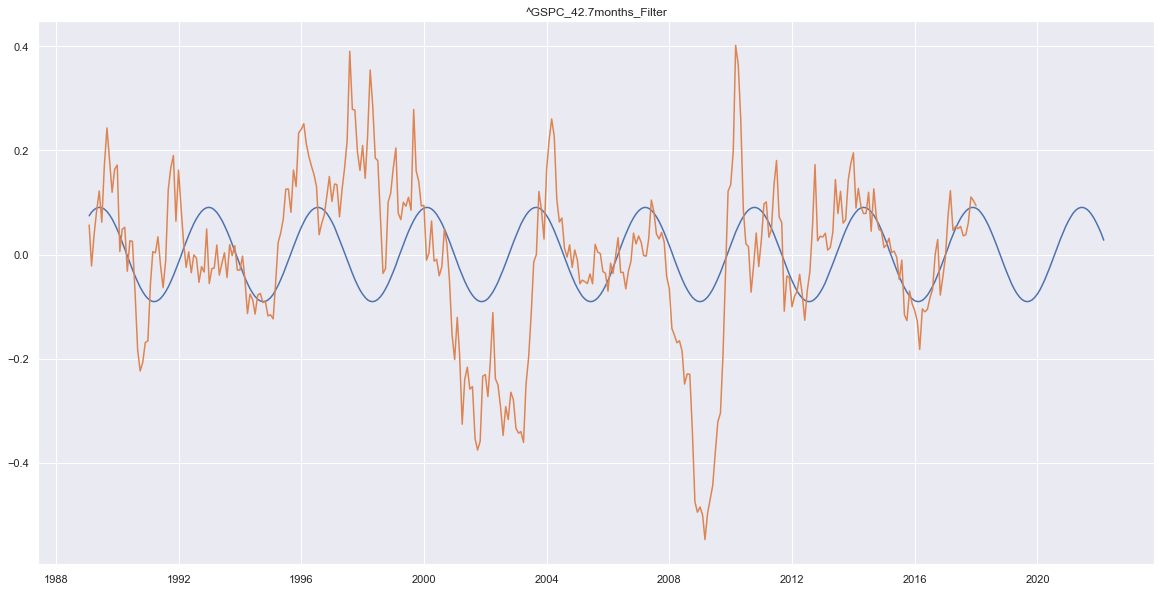

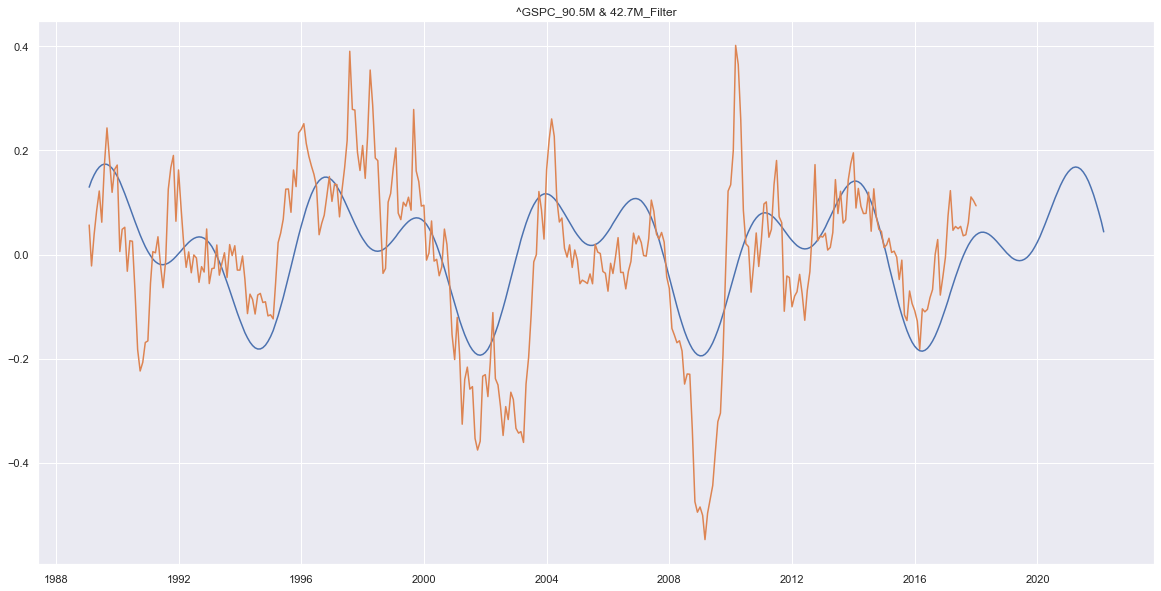

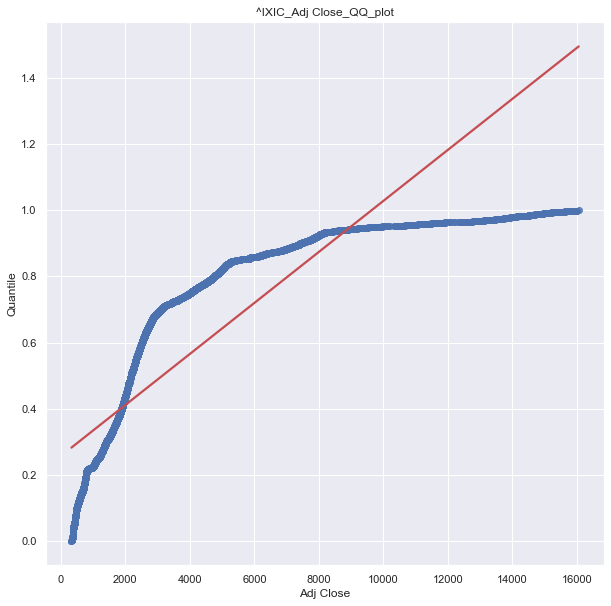

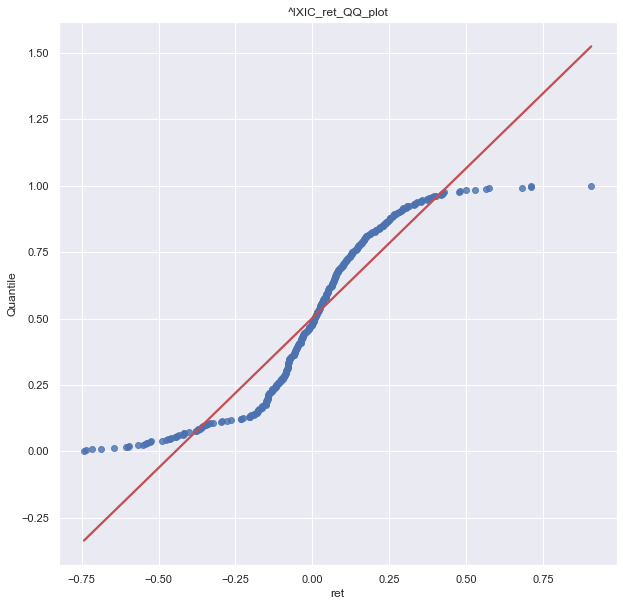

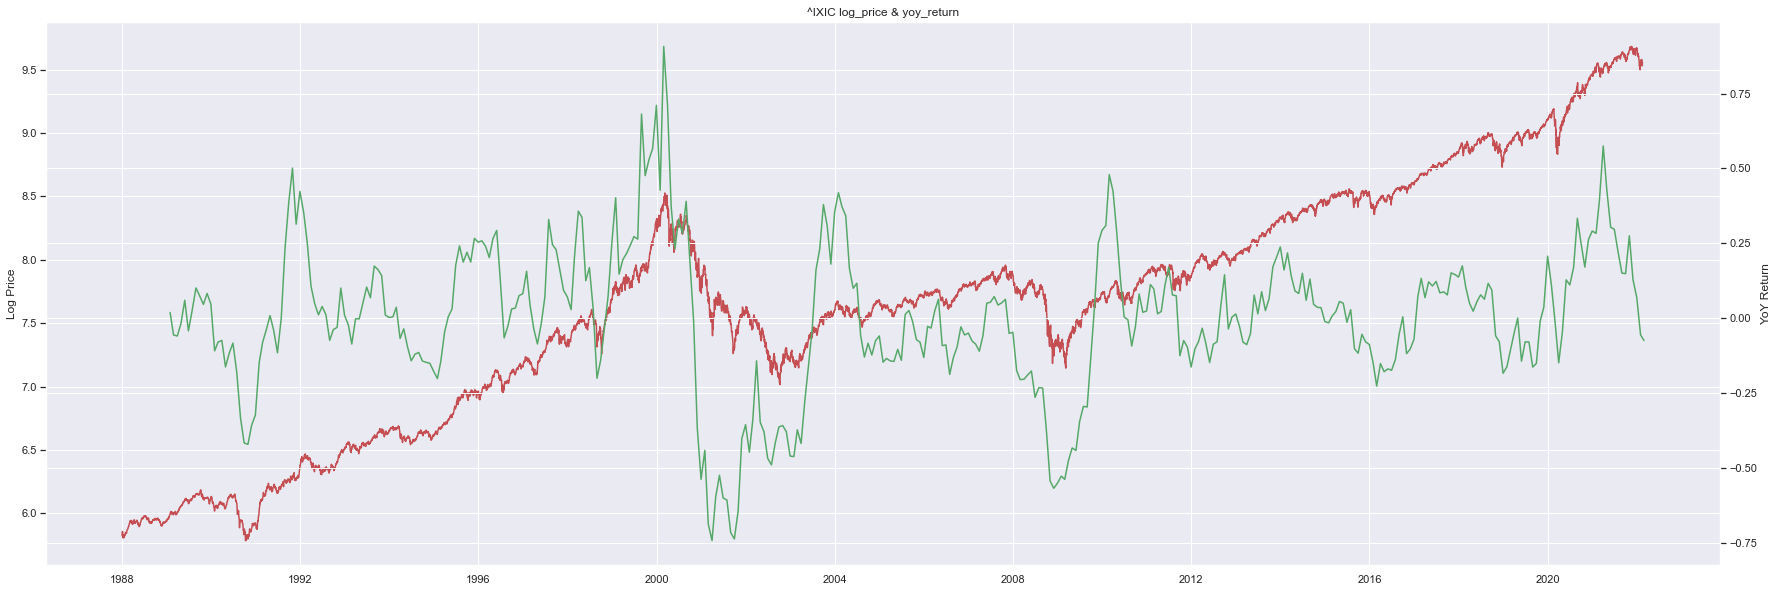

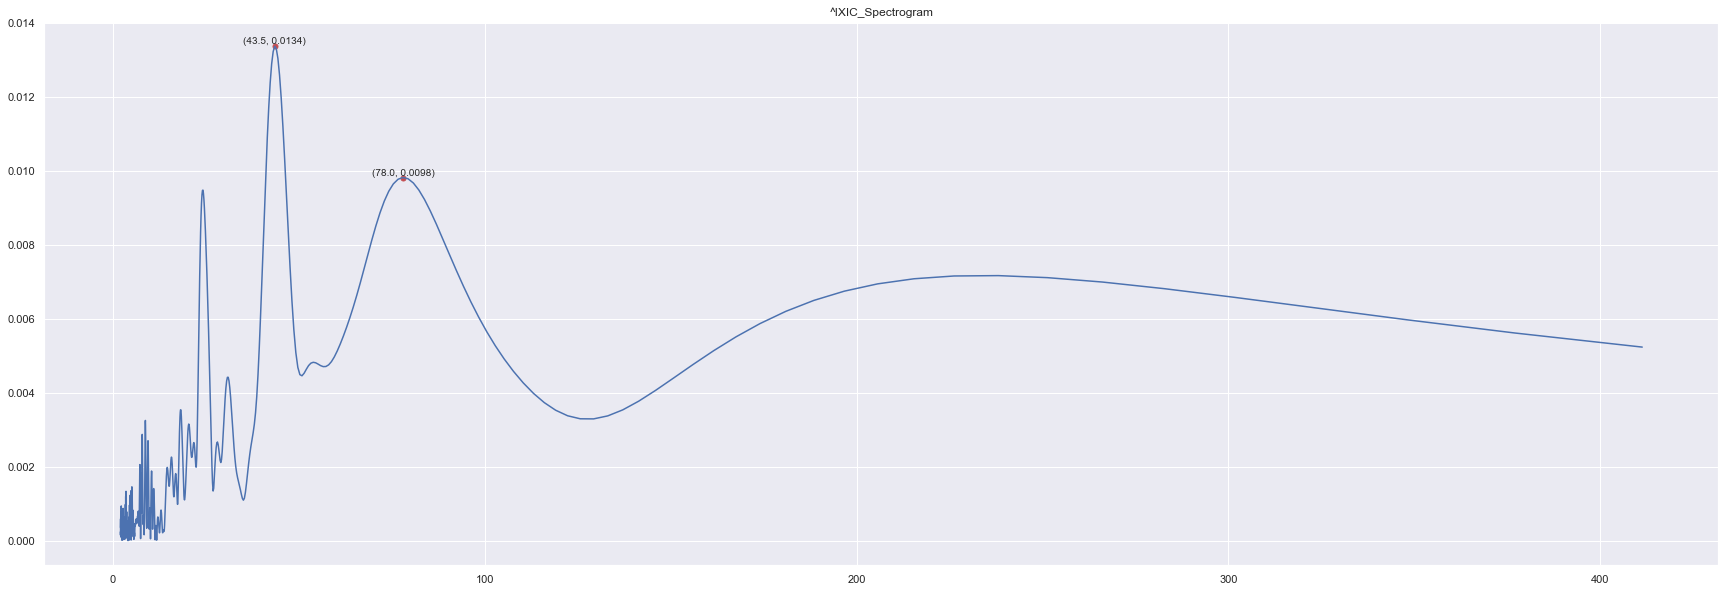

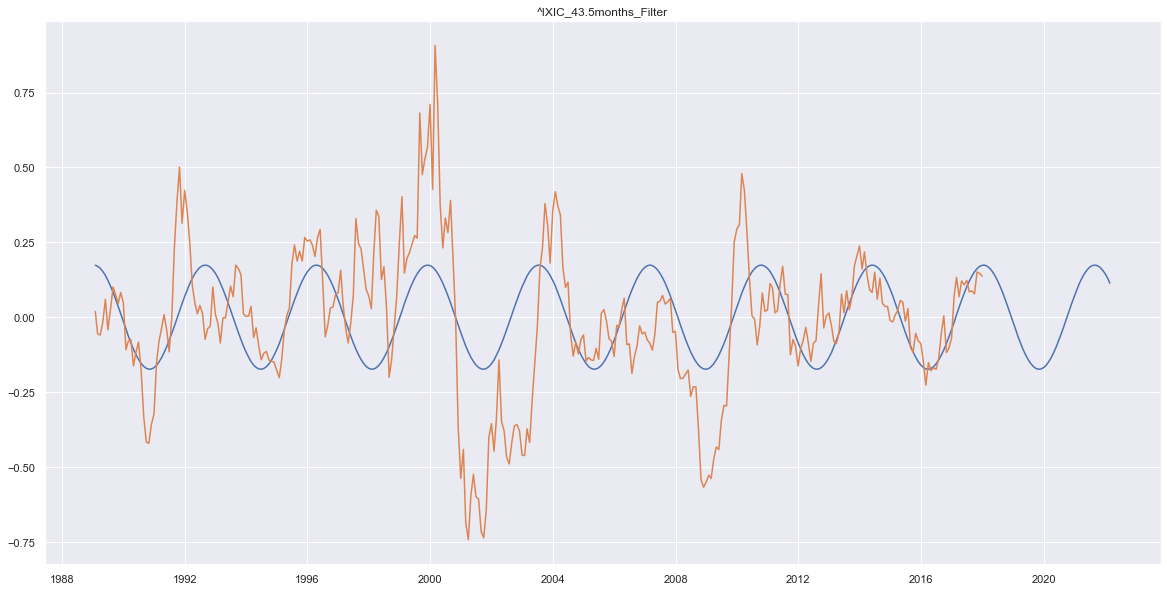

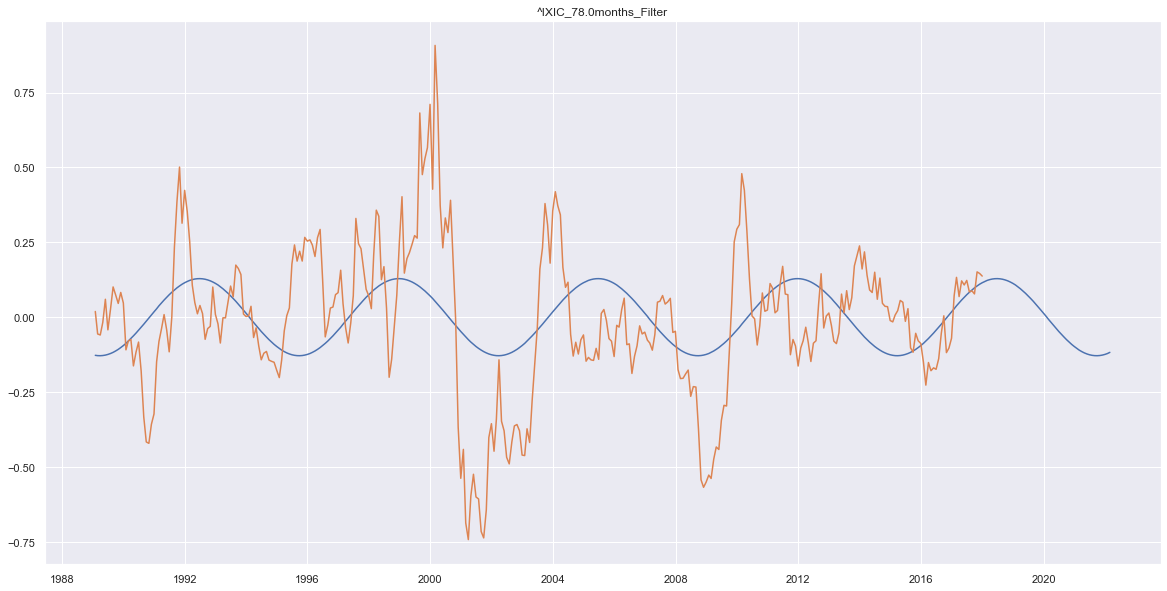

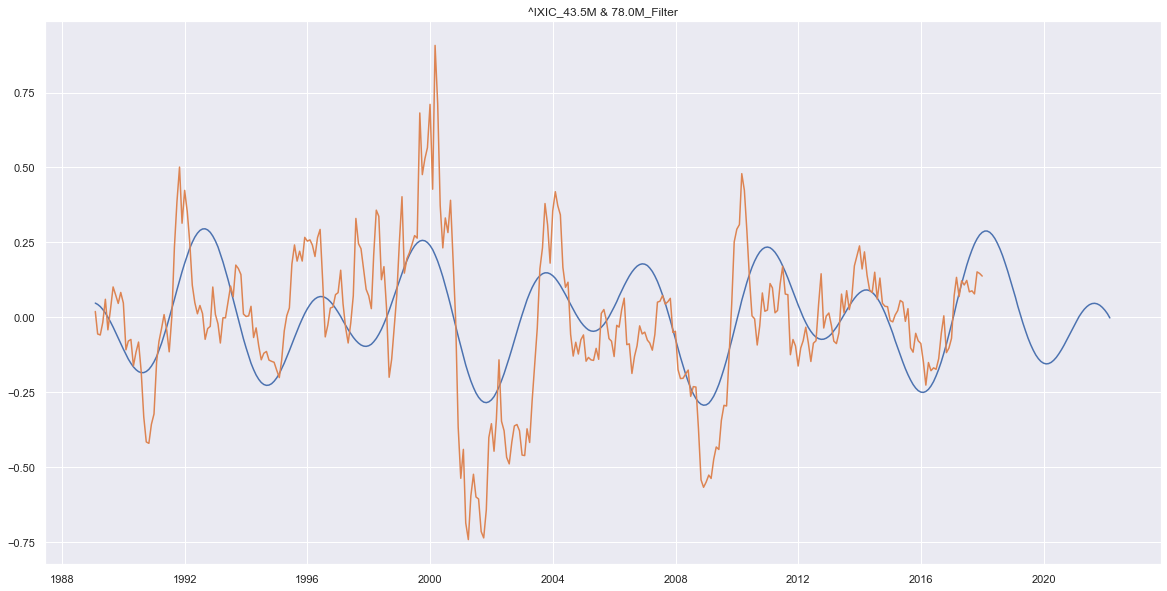

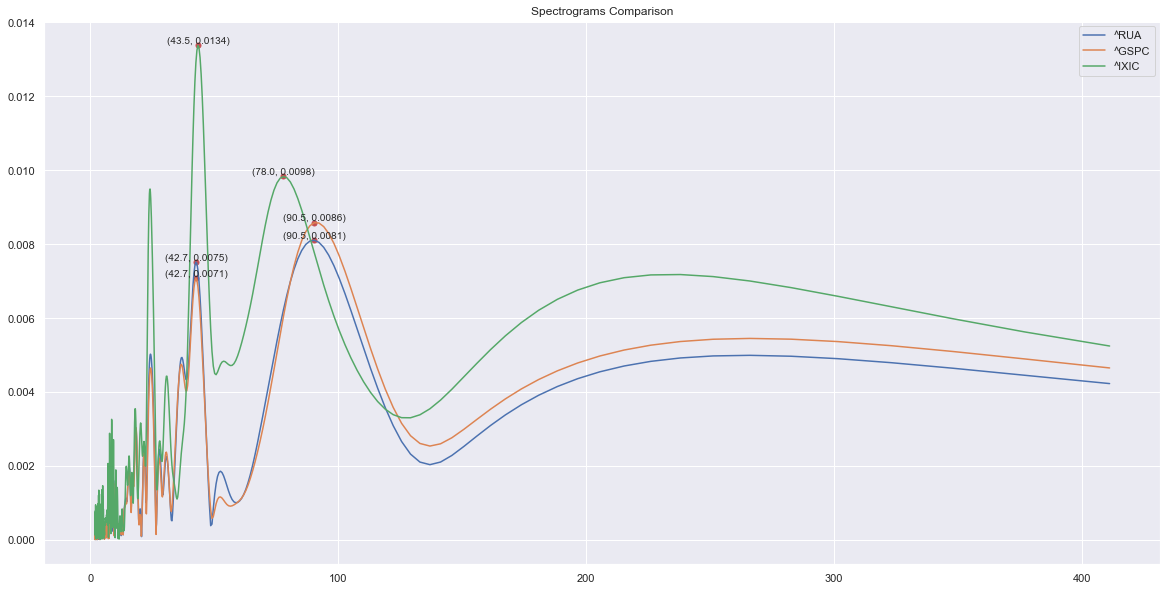

In [4]:
M = Multi_Fourier_Comparison(['^RUA', '^GSPC', '^IXIC'])
M._plot()